In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms
import matplotlib.pyplot as plt
from datetime import datetime
import math
from convlstm import ConvLSTM
from video_dataset import VideoFrameDataset
from rrunet import RR_UNET

### Load Data

In [2]:
transform = transforms.Compose([
    transforms.Pad(padding=(0, 40), padding_mode='edge'),  # Only pad width
    # transforms.Resize((256, 256)),  # Resize the now square image to 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5002, 0.4976, 0.4945], std=[0.0555, 0.0547, 0.0566])  # Standard normalization
])

root_dir = '/home/yibin/workspace/dl/final_completion/dataset_student/dataset'
train_set = VideoFrameDataset(root_dir, 'train', transform)
val_set = VideoFrameDataset(root_dir, 'val', transform)
unlabeled_set = VideoFrameDataset(root_dir, 'unlabeled', transform)
hidden_set = VideoFrameDataset(root_dir, 'hidden', transform)
batch_size = 1
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
demo_test_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(hidden_set, batch_size=batch_size, shuffle=True)

### Load Segmentation Model

In [3]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [4]:
frame_seg_model = RR_UNET(3, 49)
frame_seg_model = torch.load('/home/yibin/workspace/dl/final_completion/rrunet_seg_model-04_24_2024_222829/checkpoint.pt')
frame_seg_model.to(device)

RR_UNET(
  (conv1): RRR_block(
    (RCNN): Sequential(
      (0): Recurrent_block(
        (conv): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (1): Recurrent_block(
        (conv): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
    )
    (conv1): ResBlock(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [5]:
videos, first_frames, last_frame, video_path = next(iter(test_loader))
videos = videos.to(device)
first_frames = first_frames.to(device)
last_frame = last_frame.to(device)

In [6]:
videos.shape, first_frames.shape, last_frame.shape

(torch.Size([1, 11, 3, 240, 240]),
 torch.Size([1, 11, 3, 240, 240]),
 torch.Size([1, 3, 240, 240]))

In [7]:
def imshow(tensor):
    # Assuming tensor is normalized in the typical range for pretrained models
    mean = torch.tensor([0.5002, 0.4976, 0.4945])
    std = torch.tensor([0.0555, 0.0547, 0.0566])

    # Denormalize the image
    tensor = tensor.clone()  # Clone the tensor so not to do changes on the original
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Multiply by std and then add the mean

    # Convert tensor to image
    image = tensor.permute(1, 2, 0)  # Change from CxHxW to HxWxC format
    image = image.numpy()  # Convert to numpy array

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # No axis to show
    plt.show()

In [8]:
frame_seg_model.eval()
with torch.no_grad():
    videos, first_frames, _, path= next(iter(test_loader))
    videos = videos[:][0].to(device)
    pred = frame_seg_model(videos)
    pred = torch.argmax(pred, dim=1)
    print(torch.unique(pred[0]))

tensor([ 0, 21, 25, 28], device='cuda:3')


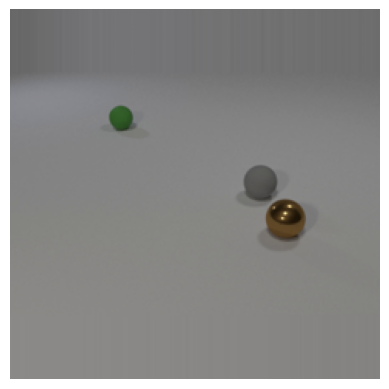

In [10]:
imshow(videos[0].cpu())

In [11]:
torch.unique(pred[0])

tensor([ 0, 21, 25, 28], device='cuda:3')

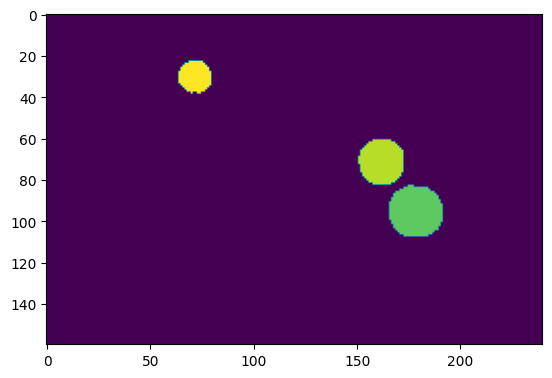

In [12]:
mask = pred[0].cpu().detach().numpy()
plt.imshow(mask)

### Generate Mask for unlabeled data and hidden data

In [13]:
frame_seg_model.eval()
with torch.no_grad():
    for i in tqdm(range(len(hidden_set))): 
        videos, _, _, video_folder= hidden_set[i]
        videos = videos.to(device)
        pred = frame_seg_model(videos)
        pred = torch.argmax(pred, dim=1)
        masks = pred.cpu().detach().numpy()
        masks = masks.astype(np.uint8)
        save_path = os.path.join(video_folder, 'mask.npy')
        np.save(save_path, masks)
        

  0%|          | 0/5000 [00:00<?, ?it/s]

In [15]:
for i in tqdm(range(len(hidden_set))):
    videos, _, _, video_folder= hidden_set[i]
    save_path = os.path.join(video_folder, 'mask.npy')
    if not os.path.exists(save_path):
        print(video_folder)


  0%|          | 0/5000 [00:00<?, ?it/s]

### Sanity Check for Mask Generation

In [16]:
masks = np.load('/home/yibin/workspace/dl/final_completion/dataset_student/dataset/hidden/video_15000/mask.npy')

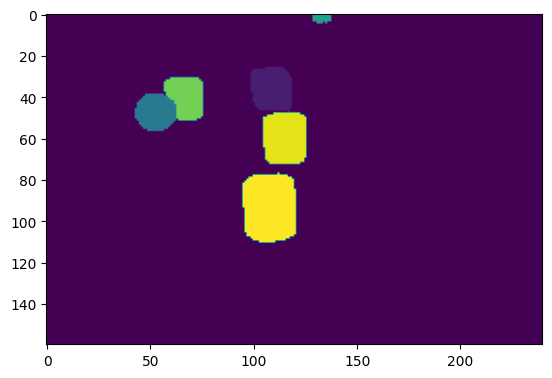

In [17]:
plt.imshow(masks[-1])